# Imports

In [62]:
from concurrent.futures import ThreadPoolExecutor
from src.erik import (
    query_database, 
    get_query_to_select_rows_by_mass, 
    relative_ppm_tolerance_in_daltons,
)
from src.plot_utils import (
    fig_setup,
    finalize,
    set_title_axes_labels,
)
import sqlite3
import time
import numpy as np
import pandas as pd
from dataclasses import dataclass
db_path = "./dbs/kmer_db_fasta=Uniprot_mouse.fasta_max_k=50_charges=[1].db"

# Basic database information

In [43]:
# Tables in DB
query = """SELECT name
FROM sqlite_master
WHERE type = 'table';"""
t0 = time.time()
r = query_database(query=query, db_path=db_path)
t1 = time.time()
print(f"Tables = {r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Indices in table
table = "kmers"
query = f"""
SELECT name
FROM sqlite_master
WHERE type = 'index' AND tbl_name = '{table}';
"""
t0 = time.time()
r = query_database(query=query, db_path=db_path)
t1 = time.time()
print(f"Indices in {table} = {r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Rows in table
query = f"SELECT COUNT(mass) FROM {table}"
t0 = time.time()
r = query_database(query=query, db_path=db_path)
t1 = time.time()
print(f"Rows in {table} table = {r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Table info
query = f"PRAGMA table_info({table});"
t0 = time.time()
r = query_database(query=query, db_path=db_path)
t1 = time.time()
print(f"{table} info:\n\t{r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Stats about table
query = f"SELECT COUNT(*), MAX(LENGTH(sequence)), MIN(mass), MAX(mass) FROM {table};"
t0 = time.time()
r = query_database(query=query, db_path=db_path)
kmer_count, max_kmer_len, min_kmer_mass, max_kmer_mass = r[0]
t1 = time.time()
print((
    f"Stats on {db_path}:\n"
    f"\t- num kmers = {kmer_count}\n"
    f"\t- min kmer mass = {min_kmer_mass}\n"
    f"\t- max kmer mass = {max_kmer_mass}\n"
    f"\t- max kmer length = {max_kmer_len}"
))
print(f"\t query took {round(t1-t0, 3)} seconds")


Tables = [('kmers',)]
	 query took 0.025 seconds
Indices in kmers = [('sqlite_autoindex_kmers_1',), ('mass_idx',)]
	 query took 0.023 seconds
Rows in kmers table = [(22732052,)]
	 query took 9.801 seconds
kmers info:
	[(0, 'id', 'INTEGER', 0, None, 1), (1, 'sequence', 'TEXT', 0, None, 0), (2, 'mass', 'REAL', 0, None, 0), (3, 'charge', 'INTEGER', 0, None, 0)]
	 query took 0.023 seconds
Stats on ./dbs/kmer_db_fasta=Uniprot_mouse.fasta_max_k=50_charges=[1].db:
	- num kmers = 22732052
	- min kmer mass = 57.021464
	- max kmer mass = 6830.4127
	- max kmer length = 50
	 query took 29.196 seconds


# Rows explaining masses

In [57]:
# Constants
# mass = 1000
# ppm_tol = 10
masses = np.arange(50, 6901, 2)
ppm_tols = [3, 5, 10, 20]
# ppm_tols = [10]

# Loop over PPM tolerances
data = []
for ppm_tol in ppm_tols:
    print(f"PPM tol = {ppm_tol}")
    # Generate queries to look for masses that explain given mass
    queries = []
    for mass in masses:
        da_tol = relative_ppm_tolerance_in_daltons(ppm=ppm_tol, ref_mass=mass)
        # print(f"Dalton tolerance for mass={mass} is {da_tol}")
        queries.append(
            get_query_to_select_rows_by_mass(mass=mass, tolerance=da_tol)
    )

    # Execute all the queries in parallel
    t0 = time.time()
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda query: query_database(query=query, db_path=db_path)[0][0], queries))
    t1 = time.time()
    print(f"\tTook {round(t1-t0, 2)} seconds for {len(queries)} queries")

    # Add results to growing array of data
    data.extend(
        [(ppm_tol, masses[ii], results[ii]) for ii in range(len(results))]
    )
# queries

PPM tol = 3
	Took 9.21 seconds for 3426 queries
PPM tol = 5
	Took 9.4 seconds for 3426 queries
PPM tol = 10
	Took 9.32 seconds for 3426 queries
PPM tol = 20
	Took 9.44 seconds for 3426 queries


In [60]:
PT, M, NEM = "ppm_tol", "mass", "num_explaining_masses"
data = pd.DataFrame(data, columns=[PT, M, NEM])

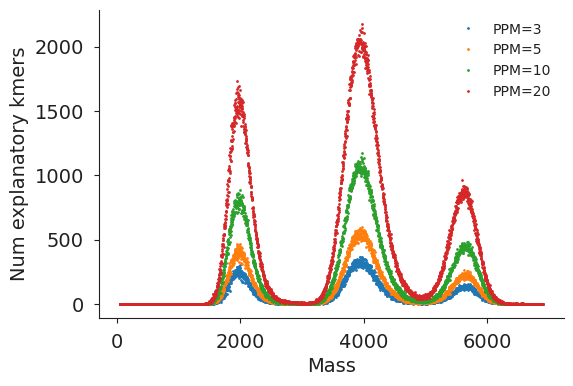

In [68]:
_, axs = fig_setup(1, 1)
for ppm_tol in ppm_tols:
    _=axs[0].plot(
        data[data[PT]==ppm_tol][M], data[data[PT]==ppm_tol][NEM],
        'o', ms=1, label=f"PPM={ppm_tol}"
    )
set_title_axes_labels(axs[0], ylabel="Num explanatory kmers", xlabel="Mass")
finalize(axs)